In [25]:
import numpy as np
import pandas as pd
import scanpy as sc

In [26]:
sc.settings.verbosity = 3

In [27]:
sc.logging.print_header()

scanpy==1.6.0 anndata==0.7.5 umap==0.4.6 numpy==1.19.2 scipy==1.5.2 pandas==1.1.3 scikit-learn==0.23.2 statsmodels==0.12.1


In [28]:
sc.settings.set_figure_params(dpi=80, facecolor='white')

In [29]:
adata = sc.read_10x_mtx('data/hg19', cache=True)

... reading from cache file cache/data-hg19-matrix.h5ad


In [30]:
adata.var_names_make_unique()

normalizing counts per cell
    finished (0:00:00)


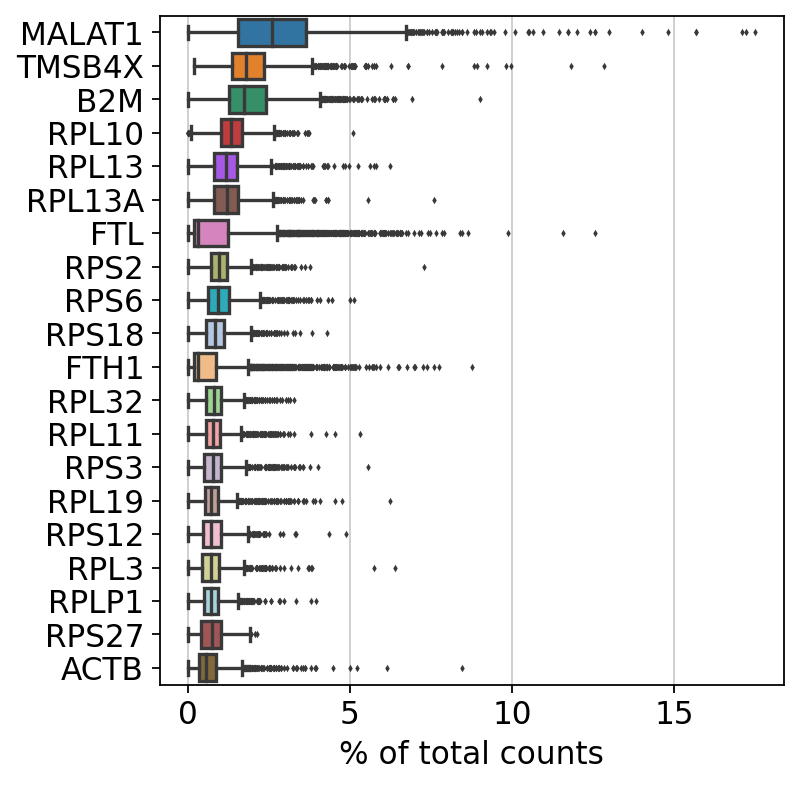

In [31]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [32]:
sc.pp.filter_cells(adata, min_genes=200)

In [33]:
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


In [34]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

/opt/conda/lib/python3.8/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/opt/conda/lib/python3.8/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/opt/conda/lib/python3.8/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/opt/conda/lib/python3.8/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/opt/conda/lib/python3.8/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/opt/conda/lib/python3.8/site-packages/seaborn/_core.py

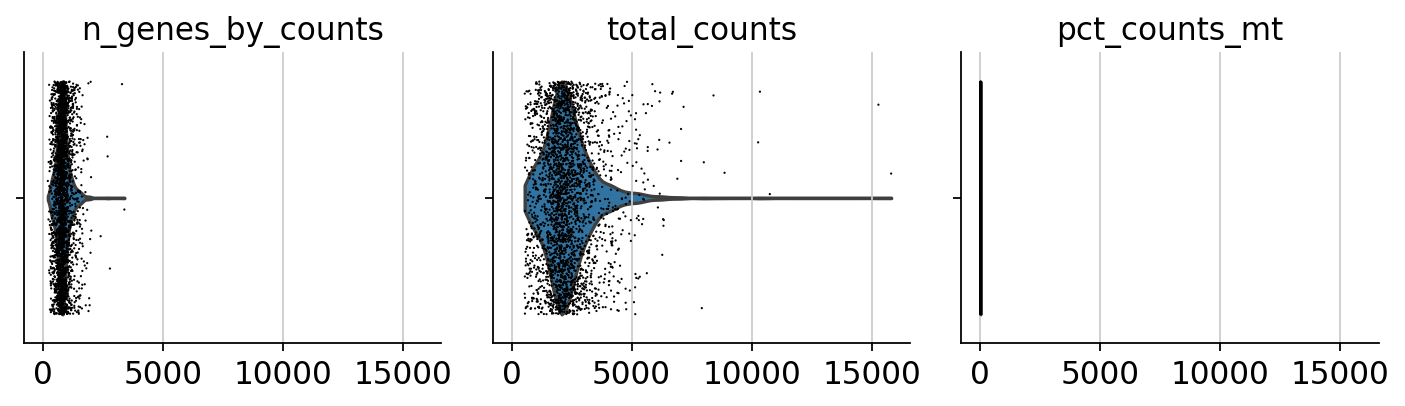

In [35]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

/opt/conda/lib/python3.8/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/opt/conda/lib/python3.8/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/opt/conda/lib/python3.8/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/opt/conda/lib/python3.8/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/opt/conda/lib/python3.8/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/opt/conda/lib/python3.8/site-packages/seaborn/_core.py

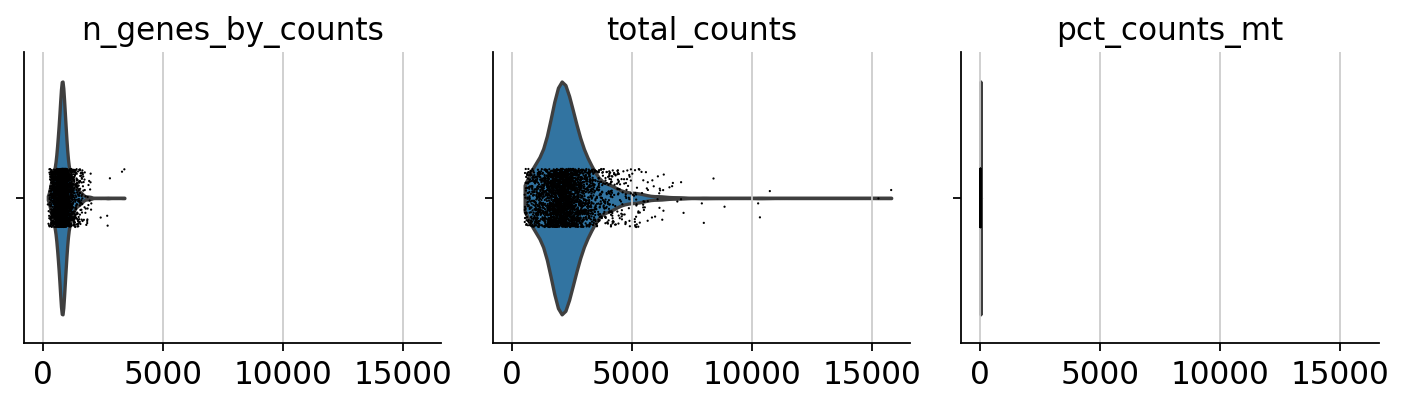

In [36]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], multi_panel=True)

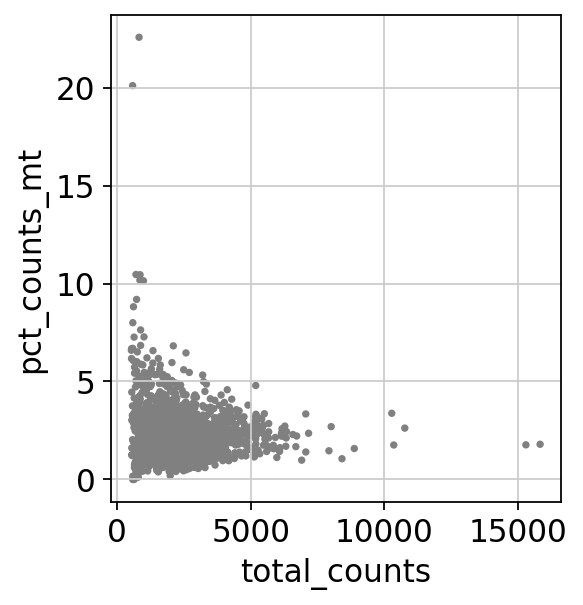

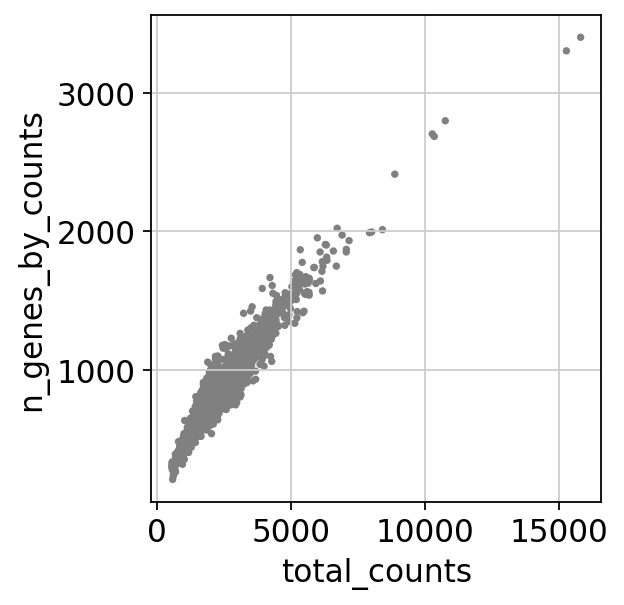

In [37]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [38]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [39]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


/opt/conda/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [40]:
sc.pp.log1p(adata)

In [49]:
import numpy as np
from scipy import sparse
import numba

# install dask if available
try:
    import dask.array as da
except ImportError:
    da = None


def get_mean_var(X, *, axis=0):
    if sparse.issparse(X):
        mean, var = sparse_mean_variance_axis(X, axis=axis)
    else:
        mean = np.mean(X, axis=axis, dtype=np.float64)
        mean_sq = np.multiply(X, X).mean(axis=axis, dtype=np.float64)
        var = mean_sq - mean ** 2
    # enforce R convention (unbiased estimator) for variance
    var *= X.shape[axis] / (X.shape[axis] - 1)
    return mean, var


def sparse_mean_variance_axis(mtx: sparse.spmatrix, axis: int) -> np.ndarray:
    """
    This code and internal functions are based on sklearns
    `sparsefuncs.mean_variance_axis`.
    Modifications:
    * allow deciding on the output type, which can increase accuracy when calculating the mean and variance of 32bit floats.
    * This doesn't currently implement support for null values, but could.
    * Uses numba not cython
    """
    assert axis in (0, 1)
    if isinstance(mtx, sparse.csr_matrix):
        ax_minor = 1
        shape = mtx.shape
    elif isinstance(mtx, sparse.csc_matrix):
        ax_minor = 0
        shape = mtx.shape[::-1]
    else:
        raise ValueError("This function only works on sparse csr and csc matrices")
    if axis == ax_minor:
        return sparse_mean_var_major_axis(
            mtx.data, mtx.indices, mtx.indptr, *shape, np.float64
        )
    else:
        return sparse_mean_var_minor_axis(mtx.data, mtx.indices, *shape, np.float64)


@numba.njit(cache=True)
def sparse_mean_var_minor_axis(
    data,
    indices,
    major_len,
    minor_len,
    dtype
) -> np.ndarray:
    """
    Computes mean and variance for a sparse matrix for the minor axis.
    Given arrays for a csr matrix, returns the means and variances for each
    column back.
    """
    non_zero = indices.shape[0]

    means = np.zeros(minor_len, dtype=dtype)
    variances = np.zeros_like(means, dtype=dtype)

    counts = np.zeros(minor_len, dtype=np.int64)

    for i in range(non_zero):
        col_ind = indices[i]
        means[col_ind] += data[i]

    for i in range(minor_len):
        means[i] /= major_len

    for i in range(non_zero):
        col_ind = indices[i]
        diff = data[i] - means[col_ind]
        variances[col_ind] += diff * diff
        counts[col_ind] += 1
    print(variances)
    for i in range(minor_len):
        variances[i] += (major_len - counts[i]) * means[i] ** 2
        variances[i] /= major_len

    return means, variances


@numba.njit(cache=True)
def sparse_mean_var_major_axis(
    data,
    indices,
    indptr,
    major_len,
    minor_len,
    dtype
) -> np.ndarray:
    """
    Computes mean and variance for a sparse array for the major axis.
    Given arrays for a csr matrix, returns the means and variances for each
    row back.
    """
    means = np.zeros(major_len, dtype=dtype)
    variances = np.zeros_like(means, dtype=dtype)

    for i in range(major_len):
        startptr = indptr[i]
        endptr = indptr[i + 1]
        counts = endptr - startptr

        for j in range(startptr, endptr):
            means[i] += data[j]
        means[i] /= minor_len

        for j in range(startptr, endptr):
            diff = data[j] - means[i]
            variances[i] += diff * diff

        variances[i] += (minor_len - counts) * means[i] ** 2
        variances[i] /= minor_len

    return means, variances

In [50]:
mean, var = get_mean_var(adata.X)

[ 22.98411426   7.97149194   9.33947306 ...  19.47314821 267.41310739
 167.29715538]


In [51]:
mean

array([0.00543551, 0.00184708, 0.00248192, ..., 0.00450927, 0.06625092,
       0.04064237])

In [52]:
var

array([0.00874546, 0.00302635, 0.00354785, ..., 0.00740486, 0.1056175 ,
       0.06505206])

In [42]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


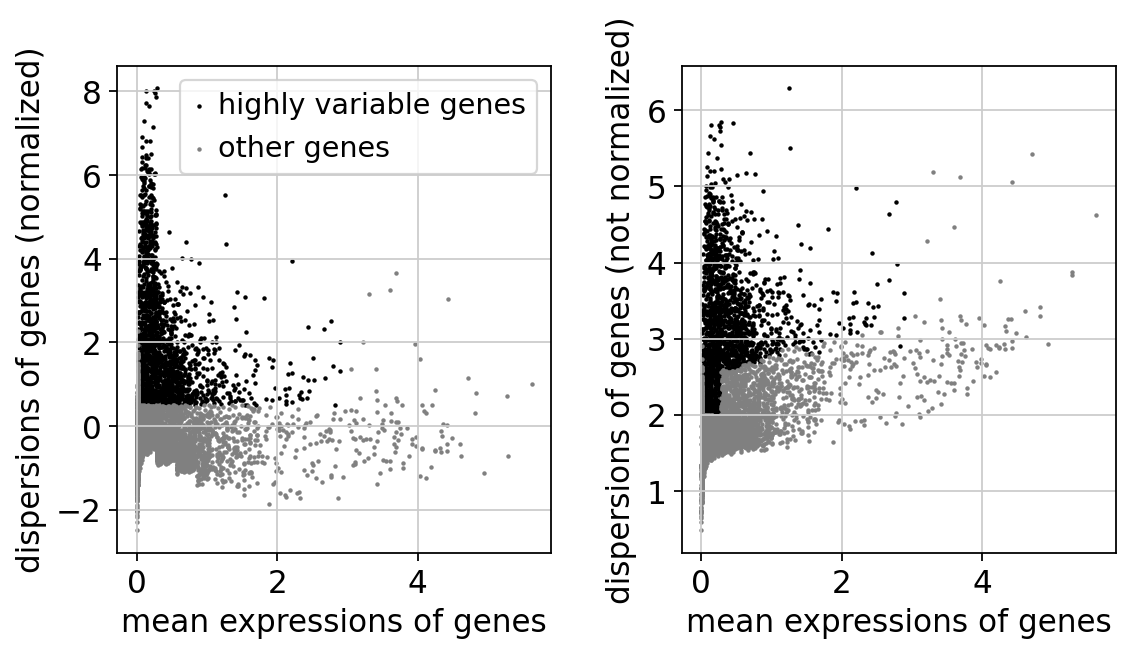

In [43]:
sc.pl.highly_variable_genes(adata)

In [44]:
adata.raw = adata

In [45]:
adata.uns

OverloadedDict, wrapping:
	OrderedDict([('log1p', {'base': None}), ('hvg', {'flavor': 'seurat'})])
With overloaded keys:
	['neighbors'].

In [46]:
adata.layers

Layers with keys: 